# Задание по классификации изображений

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.
 
Good luck & have fun! :)

In [ ]:
!pip3 install pytorch_lightning torchmetrics

In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.models.resnet import BasicBlock, ResNet
from torchmetrics import Accuracy
from typing import List, Optional, Tuple
from torchvision.models import ResNet50_Weights
from torchvision.models import EfficientNet_B2_Weights
from torchvision.models import EfficientNet_B7_Weights
from torchvision.models import ViT_B_16_Weights

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

In [4]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Задание 0

### Подготовка данных

In [5]:
seed_everything(123456)

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomVerticalFlip(0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
val_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle = False, num_workers = 1)

In [6]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

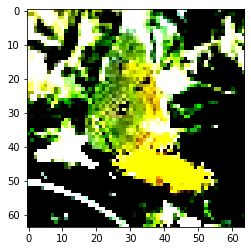

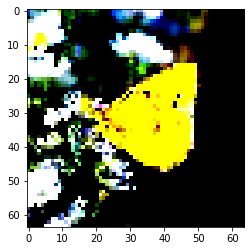

In [7]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов

Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.

### Модель (или просто импортируйте не предобученную)

In [ ]:
class YourNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = models.resnet18()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

### Тренировочный класс lightning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = YourNet().to(device)

trainer = pl.Trainer(accelerator = 'gpu', max_epochs=20)
trainer.fit(model, train_dataloader, val_dataloader)
torch.save(model, 'model.pt')

In [ ]:
!wget https://www.dropbox.com/s/s4h9x1q101c2pc5/model.pt?dl=0 # загрузка сохраненной модели
model_pre = torch.load('/content/model.pt?dl=0')

In [ ]:
class YourNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = model_pre
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr = 0.005, weight_decay = 0.005)
        self.loss = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = YourNet().to(device)

trainer = pl.Trainer(accelerator = 'gpu', max_epochs=2)
trainer.fit(model, train_dataloader, val_dataloader)

### Валидация результатов задания

In [ ]:
accuracy_score = trainer.validate(dataloaders=val_dataloader)[0]['accuracy']

print(f"Оценка за это задание составит {np.clip(10 * accuracy_score / 0.44, 0, 10):.2f} баллов")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=1-step=25000.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=1-step=25000.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.4413999915122986
        val_loss            2.3673901557922363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Подготовка данных

In [ ]:
seed_everything(123456)

weights = EfficientNet_B2_Weights.DEFAULT

preprocess = weights.transforms()

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=preprocess)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=preprocess)

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle = False, num_workers = 1)

### Модель (или просто импортируйте предобученную)

In [ ]:
class YourNet(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = models.efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 20)
        self.model.avgpool = nn.AdaptiveAvgPool2d(1)
        num_ftrs = self.model.classifier[1].in_features
        self.model.fc = nn.Linear(num_ftrs, 200)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

### Тренировочный класс lightning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = YourNet().to(device)

trainer2 = pl.Trainer(accelerator = 'gpu', max_epochs=5)
trainer2.fit(model, train_dataloader, val_dataloader)

### Валидация результатов задания

In [ ]:
accuracy_score = trainer2.validate(model = model, dataloaders=val_dataloader)[0]['accuracy']

print(f"Оценка за это задание составит {np.clip(10 * (accuracy_score - 0.5) / 0.34, 0, 10):.2f} баллов")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.7861999869346619
        val_loss            0.9265342950820923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Оценка за это задание составит 8.42 баллов


# Отчёт об экспериментах 

**Задание № 1**

Я использовал нормализацию, которую советовали во всех документациях и т.д. Трансформация тоже самая обычная: два флипа, горизонтальный и вертикальный. Что касается непосредственно самой модели, я использовал базовую resnet18, которая разбиралась на семинаре, добавил оптимайзер sgd c lr = 0.01 и momentum = 0.9. Обучил эту модель на 20 эпохах, позже она уже начинала сильно переобучаться, поэтмоу остановился на приемлемом варианте (там, где была самая большая метрика). Затем уже эту модель дообучил. Логично, что надо бы снизить шаг обучения, потому что мы уже возле минимума, поэтому я его уменьшил, также добавил weight_decay для регуляризации и dropout для борьбы с переобучением. Пробовал Adam, AdamW в качестве оптимайзеров, scheduler = CosineAnnealingLR, но именно не в совсем сложной архитектуре модели я выбил 0.441

**Задание № 2**

Посмотрел на модели в torchvision, там есть примерные accuracy на каком-то датасете (кажется, imagenet). Выбрал оптимальную модель с точки зрения метрики и кол-ва параметров - efficientnet_b2. Нормализация, трансформация у меня в соответствии с рекоумендуемыми для этой модели в статьях/отчетах. Оптимайзер самый базовый sgd с таким же шагом обучения. 


**Что использовал:** 

https://pytorch.org/hub/pytorch_vision_resnet/, https://pytorch.org/torchx/latest/examples_apps/lightning_classy_vision/model.html, https://medium.com/@lokeshpara17/tiny-imagenet-using-pytorch-42a3f2ee3c9d, https://github.com/lokeshpara/Freecodecamp/tree/master/course_project, https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1, https://pytorch.org/vision/stable/models.html
